In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler  # for normalization
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.svm import SVC
from sklearn.datasets import make_classification
import torch
from sklearn.utils import shuffle

   feature_1  feature_2  feature_3  feature_4  target
0  -0.048471  -0.365467  -1.388806  -2.047891       0
1  -1.554525   1.827180   1.855921   1.969595       1
2  -2.346513  -0.656112  -0.082882  -0.028047       0
3   1.538406  -2.535597  -1.884151  -2.347240       0
4  -1.776567  -0.094210  -1.200439  -0.829714       0


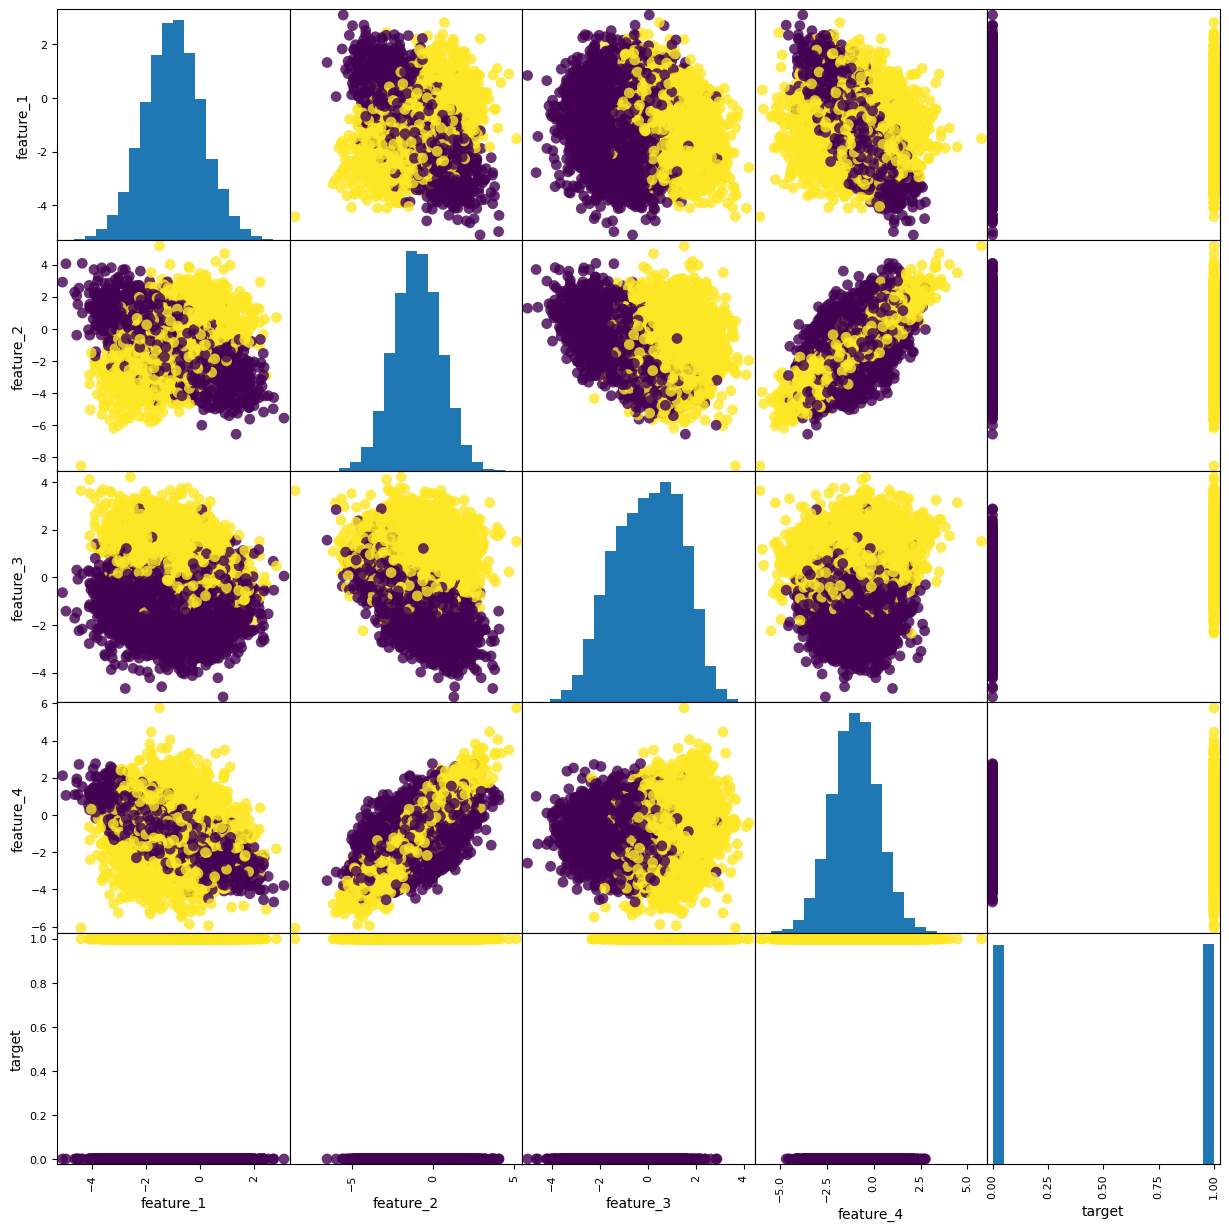

In [90]:
# Generate the dataset
x, y = make_classification(n_samples=10000,    # Number of samples
                           n_features=4,      # Number of features
                           n_informative=4,   # Number of informative features
                           n_redundant=0,     # Number of redundant features
                           n_clusters_per_class=1,
                           random_state=42)

# Convert to a DataFrame
df = pd.DataFrame(x, columns=[f'feature_{i}' for i in range(1, 5)])
df['target'] = y

# Display the first few rows of the dataset
print(df.head())

# Optional: Visualize the dataset
# Since there are 6 features, let's plot pairs of features
pd.plotting.scatter_matrix(df.iloc[:, :6], c=df['target'], figsize=(15, 15), marker='o',
                           hist_kwds={'bins': 20}, s=60, alpha=.8)
plt.show()

In [101]:
xtr, xtest, ytr, ytest = train_test_split(x, y, test_size = 0.15, random_state = 42)
xtr.shape, ytr.shape, xtest.shape, ytest.shape

((8500, 4), (8500,), (1500, 4), (1500,))

In [92]:
xtr = torch.tensor(xtr, dtype = torch.float32, requires_grad = False)
ytr = torch.tensor(ytr, dtype = torch.float32, requires_grad = False)
xtest = torch.tensor(xtest, dtype = torch.float32, requires_grad = False)
xtr.shape, ytr.shape

(torch.Size([8500, 4]), torch.Size([8500]))

In [78]:
# hinge loss function - L(y,f(x))=max(0,1−y⋅f(x))
# the J(w,b) = 1/2 * det(w) **2 + c * sum(max(0, 1 - yi * (wT @ xi + b)))
# here the output of yi * (wT @ xi + b) is an [1] vector, moreover the shapes of yi is [1], wT is [1, m] and xi is [m, 1] where m is the no of featueres
# and shape of b is [1]. For easier implementation xi @ w, which will give the exact same result because shape of xi in each iteration will be [1, m] and
# shape of w is [m, 1].
# dJ/dw = w if max(0, 1 - yi * (wT @ xi + b)) == 0
#         w - c * sum(yi * xi) otherwise
# dJ/db = -c * sum(yi)

In [ ]:
# implementing using stochastic gradient descent - where the cost is computed separately for each variable
# hyper parameters
c = 1.0
learning_rate = 0.01
num_epochs = 25
w = torch.zeros(xtr.shape[1], requires_grad = False)
b = torch.zeros(1, requires_grad = False)
print(w.shape, b.shape)

for i in range (num_epochs):
    total_loss = 0.0
    for j in range(len(xtr)):
        margin = ytr[j] * (torch.dot(xtr[j], w) + b)
        loss = torch.max(torch.tensor(0.0), 1 - margin)
        
        total_loss += loss.item()
        
        if margin < 1:
            w = w - learning_rate * (w - c * ytr[j] * xtr[j])
            b = b - learning_rate * (-c * ytr[j])
        else:
            w = w - learning_rate * w
        #print(f'iteration - {j}, epochs - {i}, margin - {margin}, loss - {loss}, w - {w}, b - {b}')
    print(f'loss for iteration {i} is {total_loss}')
w = w.detach().numpy()
b = b.item()

In [ ]:
# Hyperparameters
c = 1.0
learning_rate = 0.1
num_epochs = 100

# Initialize weights and bias
w = torch.zeros(xtr.shape[1], requires_grad=False)
b = torch.zeros(1, requires_grad=False)
loss_vals = []
# Gradient Descent for SVM
for epoch in range(num_epochs):
    if epoch > 50:
        learning_rate = 0.01
    total_loss = 0.0
    w_grad = torch.zeros_like(w)
    b_grad = torch.zeros_like(b)
    
    for j in range(len(xtr)):
        margin = ytr[j] * (torch.dot(xtr[j], w) + b)
        loss = torch.max(torch.tensor(0.0), 1 - margin)
        
        total_loss += loss.item()
        
        if margin < 1:
            w_grad += w - c * ytr[j] * xtr[j]
            b_grad += -c * ytr[j]
        else:
            w_grad += w
    
    # Update weights and bias
    w -= learning_rate * w_grad / len(xtr)
    b -= learning_rate * b_grad / len(xtr)
    loss_vals.append(total_loss)
    print(f'Loss for epoch {epoch} is {total_loss}')

# Convert final weights and bias to numpy
w = w.detach().numpy()
b = b.item()

In [111]:
def compute_cost(W, X, Y, reg_strength = 1.0):
    # calculate hinge loss
    N = X.shape[0]
    distances = 1 - Y * (np.dot(X, W))
    distances[distances < 0] = 0  # equivalent to max(0, distance)
    hinge_loss = reg_strength * (np.sum(distances) / N)
    
    # calculate cost
    cost = 1 / 2 * np.dot(W, W) + hinge_loss
    return cost

def calculate_cost_gradient(W, X_batch, Y_batch, reg_strength = 1.0):
    # if only one example is passed (eg. in case of SGD)
    if isinstance(Y_batch, np.float64) or isinstance(Y_batch, np.int64):
        Y_batch = np.array([Y_batch])
        X_batch = np.array([X_batch])
    distance = 1 - (Y_batch * np.dot(X_batch, W))
    dw = np.zeros(len(W))
    for ind, d in enumerate(distance):
        if max(0, d) == 0:
            di = W
        else:
            di = W - (reg_strength * Y_batch[ind] * X_batch[ind])
        dw += di
    dw = dw/len(Y_batch)  # average
    return dw

def sgd(features, outputs):
    max_epochs = 1000
    weights = np.zeros(features.shape[1])
    nth = 0
    prev_cost = float("inf")
    cost_threshold = 0.01  # in percent
    # stochastic gradient descent
    for epoch in range(1, max_epochs):
        # shuffle to prevent repeating update cycles
        X, Y = shuffle(features, outputs)
        for ind, x in enumerate(X):
            ascent = calculate_cost_gradient(weights, x, Y[ind])
            weights = weights - (learning_rate * ascent)
        # convergence check on 2^nth epoch
        if epoch == 2 ** nth or epoch == max_epochs - 1:
            cost = compute_cost(weights, features, outputs)
            print("Epoch is:{} and Cost is: {}".format(epoch, cost))
            # stoppage criterion
            if abs(prev_cost - cost) < cost_threshold * prev_cost:
                return weights
            prev_cost = cost
            nth += 1
    return weights

# inside init()
# train the model
print("training started...")
W = sgd(xtr, ytr)
print("training finished.")
print("weights are: {}".format(W))

training started...
Epoch is:1 and Cost is: 0.7686664891584771
Epoch is:2 and Cost is: 0.759633708622107
Epoch is:4 and Cost is: 0.7608749350401737
training finished.
weights are: [-0.19180921 -0.07904375  0.27773346 -0.16051759]


In [112]:
def predict(x, w, b):
    decision_values = (x @ w) + b
    return np.where(decision_values > 0, 1, 0)

pred = predict(xtest, W, 1.0)
print(f'recall score {recall_score(ytest, pred)}')
print(f'precision score {precision_score(ytest, pred)}')

recall score 1.0
precision score 0.48964595858383436


In [113]:
pred

array([1, 1, 1, ..., 1, 1, 1])